# Proyecto Integrador IV
> E-Commerce Data Pipeline

En este notebook, primero ejecutaremos todos los componentes de nuestro pipeline ELT y luego realizaremos visualizaciones con la información resultante


In [1]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

In [2]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

### 1. Extract

Aquí estarás extrayendo la información de las fuentes.

In [3]:
print("🚀 INICIANDO PROCESO DE EXTRACCIÓN...")
print("=" * 50)

# Configuración de rutas y URLs
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

print(f"📁 Carpeta de datasets: {csv_folder}")
print(f"🌐 URL de feriados públicos: {public_holidays_url}")

# 1. Get the mapping of the csv files to the table names.
print("\n📋 PASO 1: Obteniendo mapeo de archivos CSV a tablas...")
csv_table_mapping = config.get_csv_to_table_mapping()
print(f"✅ Se configuraron {len(csv_table_mapping)} archivos CSV:")
for csv_file, table_name in csv_table_mapping.items():
    print(f"   • {csv_file} → {table_name}")

# 2. Extract the data from the csv files, holidays and load them into the dataframes.
print("\n🔄 PASO 2: Extrayendo datos de archivos CSV y feriados públicos...")
print("⏳ Procesando archivos...")

csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)

print(f"\n✅ EXTRACCIÓN COMPLETADA EXITOSAMENTE!")
print(f"📊 Total de DataFrames extraídos: {len(csv_dataframes)}")
print("\n📈 Resumen de datos extraídos:")
total_rows = 0
for table_name, df in csv_dataframes.items():
    rows, cols = df.shape
    total_rows += rows
    print(f"   • {table_name}: {rows:,} filas, {cols} columnas")

print(f"\n🎯 TOTAL DE REGISTROS PROCESADOS: {total_rows:,}")
print("=" * 50)

🚀 INICIANDO PROCESO DE EXTRACCIÓN...
📁 Carpeta de datasets: c:\Users\eulic\Documents\Proyecto integrado 4\proyecto_integrador (2)\dataset
🌐 URL de feriados públicos: https://date.nager.at/api/v3/publicholidays

📋 PASO 1: Obteniendo mapeo de archivos CSV a tablas...
✅ Se configuraron 9 archivos CSV:
   • olist_customers_dataset.csv → olist_customers
   • olist_geolocation_dataset.csv → olist_geolocation
   • olist_order_items_dataset.csv → olist_order_items
   • olist_order_payments_dataset.csv → olist_order_payments
   • olist_order_reviews_dataset.csv → olist_order_reviews
   • olist_orders_dataset.csv → olist_orders
   • olist_products_dataset.csv → olist_products
   • olist_sellers_dataset.csv → olist_sellers
   • product_category_name_translation.csv → product_category_name_translation

🔄 PASO 2: Extrayendo datos de archivos CSV y feriados públicos...
⏳ Procesando archivos...

✅ EXTRACCIÓN COMPLETADA EXITOSAMENTE!
📊 Total de DataFrames extraídos: 10

📈 Resumen de datos extraídos:
 

### 2. Load

Usando los diferentes conjuntos de datos proporcionados, almacenarás todo en nuestro Data Warehouse.

In [4]:
print("🗄️ INICIANDO PROCESO DE CARGA A BASE DE DATOS...")
print("=" * 50)

print(f"📊 DataFrames disponibles para cargar: {len(csv_dataframes)}")
print(f"🎯 Base de datos destino: {config.SQLITE_BD_ABSOLUTE_PATH}")

# Mostrar resumen de lo que se va a cargar
print("\n📋 RESUMEN DE DATOS A CARGAR:")
total_rows_to_load = 0
for table_name, df in csv_dataframes.items():
    rows, cols = df.shape
    total_rows_to_load += rows
    print(f"   • {table_name}: {rows:,} registros")

print(f"\n🔢 TOTAL DE REGISTROS A CARGAR: {total_rows_to_load:,}")

print("\n⏳ CARGANDO DATOS EN LA BASE DE DATOS...")
print("🔄 Procesando tablas...")

# Ejecutar la carga
load(data_frames=csv_dataframes, database=ENGINE)

print("\n✅ CARGA COMPLETADA EXITOSAMENTE!")
print("🎉 Todos los DataFrames han sido cargados en la base de datos SQLite")
print("=" * 50)

🗄️ INICIANDO PROCESO DE CARGA A BASE DE DATOS...
📊 DataFrames disponibles para cargar: 10
🎯 Base de datos destino: c:\Users\eulic\Documents\Proyecto integrado 4\proyecto_integrador (2)\olist.db

📋 RESUMEN DE DATOS A CARGAR:
   • olist_customers: 99,441 registros
   • olist_geolocation: 1,000,163 registros
   • olist_order_items: 112,650 registros
   • olist_order_payments: 103,886 registros
   • olist_order_reviews: 99,224 registros
   • olist_orders: 99,441 registros
   • olist_products: 32,951 registros
   • olist_sellers: 3,095 registros
   • product_category_name_translation: 71 registros
   • public_holidays: 14 registros

🔢 TOTAL DE REGISTROS A CARGAR: 1,550,936

⏳ CARGANDO DATOS EN LA BASE DE DATOS...
🔄 Procesando tablas...

✅ CARGA COMPLETADA EXITOSAMENTE!
🎉 Todos los DataFrames han sido cargados en la base de datos SQLite


In [5]:
# Verificar si la extracción y carga funcionaron correctamente
from sqlalchemy import inspect, text

print("=== VERIFICACIÓN DE EXTRACCIÓN ===")
print(f"Número de DataFrames extraídos: {len(csv_dataframes)}")
print("Tablas extraídas:")
for table_name, df in csv_dataframes.items():
    print(f"  - {table_name}: {df.shape[0]} filas, {df.shape[1]} columnas")

print("\n=== VERIFICACIÓN DE CARGA A BASE DE DATOS ===")
# Verificar las tablas en la base de datos
inspector = inspect(ENGINE)
tables_in_db = inspector.get_table_names()
print(f"Número de tablas en la base de datos: {len(tables_in_db)}")
print("Tablas en la base de datos:")
for table in tables_in_db:
    print(f"  - {table}")

# Verificar algunos registros de una tabla como ejemplo
if tables_in_db:
    sample_table = tables_in_db[0]
    with ENGINE.connect() as conn:
        result = conn.execute(text(f"SELECT COUNT(*) FROM {sample_table}"))
        count = result.fetchone()[0]
        print(f"\nEjemplo - Tabla '{sample_table}' tiene {count} registros")
        
        # Mostrar primeras 3 filas de la tabla de ejemplo
        sample_data = conn.execute(text(f"SELECT * FROM {sample_table} LIMIT 3"))
        print(f"Primeras 3 filas de '{sample_table}':")
        for i, row in enumerate(sample_data, 1):
            print(f"  Fila {i}: {row}")
else:
    print("⚠️ No se encontraron tablas en la base de datos")

print("\n✅ RESUMEN:")
print(f"✅ Extracción exitosa: {len(csv_dataframes)} DataFrames cargados")
print(f"✅ Carga exitosa: {len(tables_in_db)} tablas en la base de datos")

=== VERIFICACIÓN DE EXTRACCIÓN ===
Número de DataFrames extraídos: 10
Tablas extraídas:
  - olist_customers: 99441 filas, 5 columnas
  - olist_geolocation: 1000163 filas, 5 columnas
  - olist_order_items: 112650 filas, 7 columnas
  - olist_order_payments: 103886 filas, 5 columnas
  - olist_order_reviews: 99224 filas, 7 columnas
  - olist_orders: 99441 filas, 8 columnas
  - olist_products: 32951 filas, 9 columnas
  - olist_sellers: 3095 filas, 4 columnas
  - product_category_name_translation: 71 filas, 2 columnas
  - public_holidays: 14 filas, 7 columnas

=== VERIFICACIÓN DE CARGA A BASE DE DATOS ===
Número de tablas en la base de datos: 10
Tablas en la base de datos:
  - olist_customers
  - olist_geolocation
  - olist_order_items
  - olist_order_payments
  - olist_order_reviews
  - olist_orders
  - olist_products
  - olist_sellers
  - product_category_name_translation
  - public_holidays

Ejemplo - Tabla 'olist_customers' tiene 99441 registros
Primeras 3 filas de 'olist_customers':
  F

### 3. Transform

Aquí transformarás las diferentes consultas en tablas. Hay dos secciones: una con las consultas relacionadas con los ingresos y otra con las consultas relacionadas con las entregas.

##### 3.1 Queries sobre ingresos

In [6]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

In [7]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,38697.02,993201.05
1,02,Feb,0.00,228077.41,874903.26
2,03,Mar,0.00,387208.44,1043575.50
3,04,Apr,0.00,307684.28,1300707.56
4,05,May,0.00,600639.16,1170436.47
5,06,Jun,0.00,502044.55,1171020.32
6,07,Jul,0.00,531115.58,947840.37
7,08,Aug,0.00,627308.62,1347294.08
8,09,Sep,0.00,670035.60,12875.18
9,10,Oct,34310.74,759839.35,347.95


In [8]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,health_beauty,8647,1412089.53
1,watches_gifts,5493,1264016.98
2,bed_bath_table,9272,1225209.26
3,sports_leisure,7529,1118062.91
4,computers_accessories,6529,1032603.65
5,furniture_decor,6307,880329.92
6,housewares,5743,758392.25
7,cool_stuff,3559,691680.89
8,auto,3809,669319.92
9,garden_tools,3448,567145.68


In [9]:
# Configuración específica para Plotly en Jupyter notebooks
import plotly.io as pio
import plotly.offline as py

# Configurar Plotly para usar el renderer correcto en notebooks
pio.renderers.default = "notebook"
py.init_notebook_mode(connected=True)

print("✅ Plotly configurado correctamente para Jupyter notebooks")

✅ Plotly configurado correctamente para Jupyter notebooks


In [10]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,598.67
2,cds_dvds_musicals,12,954.99
3,home_comfort_2,24,1170.58
4,flowers,29,1598.91
5,diapers_and_hygiene,25,2046.19
6,arts_and_craftmanship,23,2184.14
7,la_cuisine,13,2388.54
8,fashion_sport,26,2657.55
9,fashio_female_clothing,36,3218.44


In [11]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5768518.23
1,RJ,2055401.57
2,MG,1818891.67
3,RS,861278.79
4,PR,781708.80
5,SC,595127.78
6,BA,591137.81
7,DF,346123.35
8,GO,334212.35
9,ES,317657.93


##### 3.2 Queries sobre entregas

In [12]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,BA,10
3,CE,10
4,ES,10
5,SE,10
6,MS,11
7,PI,11
8,RJ,11
9,SC,11


In [13]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,NaN,12.647044,14.080563,NaN,39.508831,26.302555
1,02,Feb,NaN,13.168825,16.945138,NaN,31.848929,24.528996
2,03,Mar,NaN,12.951184,16.301410,NaN,24.732386,22.033067
3,04,Apr,NaN,14.917913,11.499241,NaN,27.349810,23.679546
4,05,May,NaN,11.322363,11.419029,NaN,24.284784,22.891488
5,06,Jun,NaN,12.011573,9.239216,NaN,24.021864,27.772740
6,07,Jul,NaN,11.592732,8.958636,NaN,23.317316,19.690127
7,08,Aug,NaN,11.147125,7.732780,NaN,23.480603,15.186330
8,09,Sep,54.813194,11.851007,NaN,18.488449,22.437366,NaN
9,10,Oct,19.600559,11.856700,NaN,55.676632,23.019536,NaN


In [14]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [15]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,order_count,date,holiday
0,32,1483574400000,False
1,4,1483660800000,False
2,4,1483747200000,False
3,6,1483833600000,False
4,5,1483920000000,False
...,...,...,...
356,167,1514332800000,False
357,146,1514419200000,False
358,135,1514505600000,False
359,97,1514592000000,False


In [16]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

### 4. Graficas de las tablas resultantes

Ahora, crearemos gráficos a partir de las diferentes consultas.

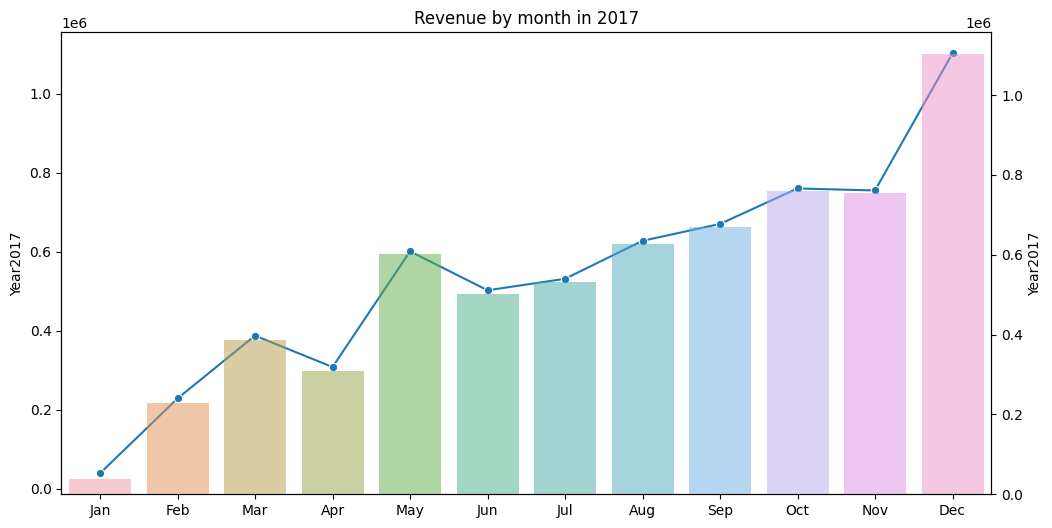

In [17]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [18]:
plot_top_10_revenue_categories(top_10_revenue_categories)

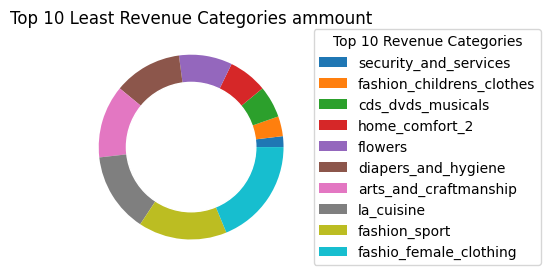

In [19]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [20]:
plot_revenue_per_state(revenue_per_state)

In [21]:
# Recargar el módulo plots con las correcciones para plot_revenue_per_state
import importlib
import src.plots
importlib.reload(src.plots)
from src.plots import *

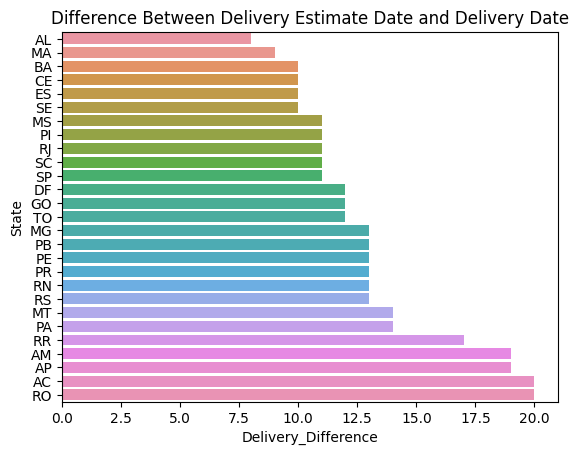

In [22]:
plot_delivery_date_difference(delivery_date_difference)

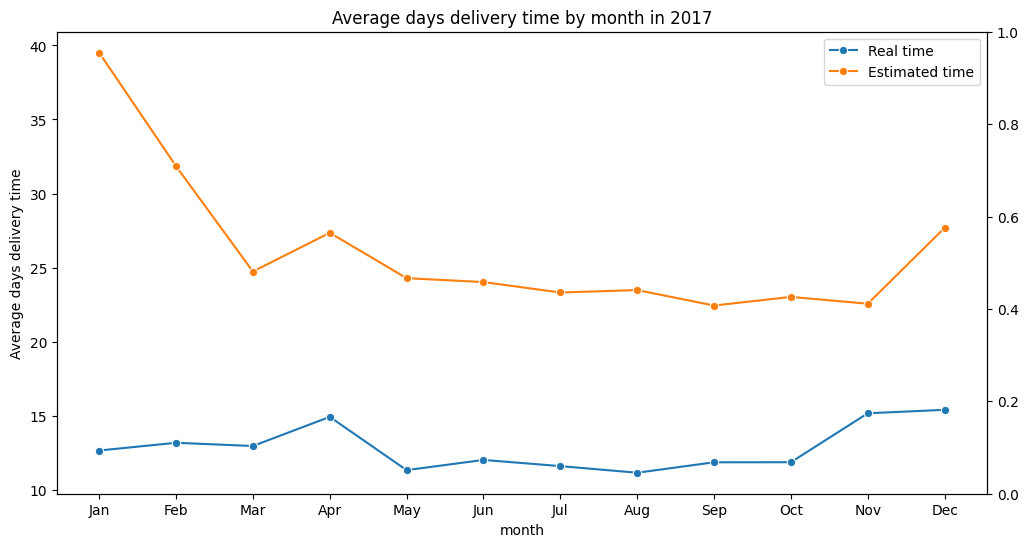

In [23]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

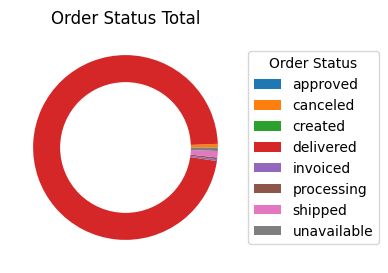

In [24]:
plot_global_amount_order_status(global_ammount_order_status)

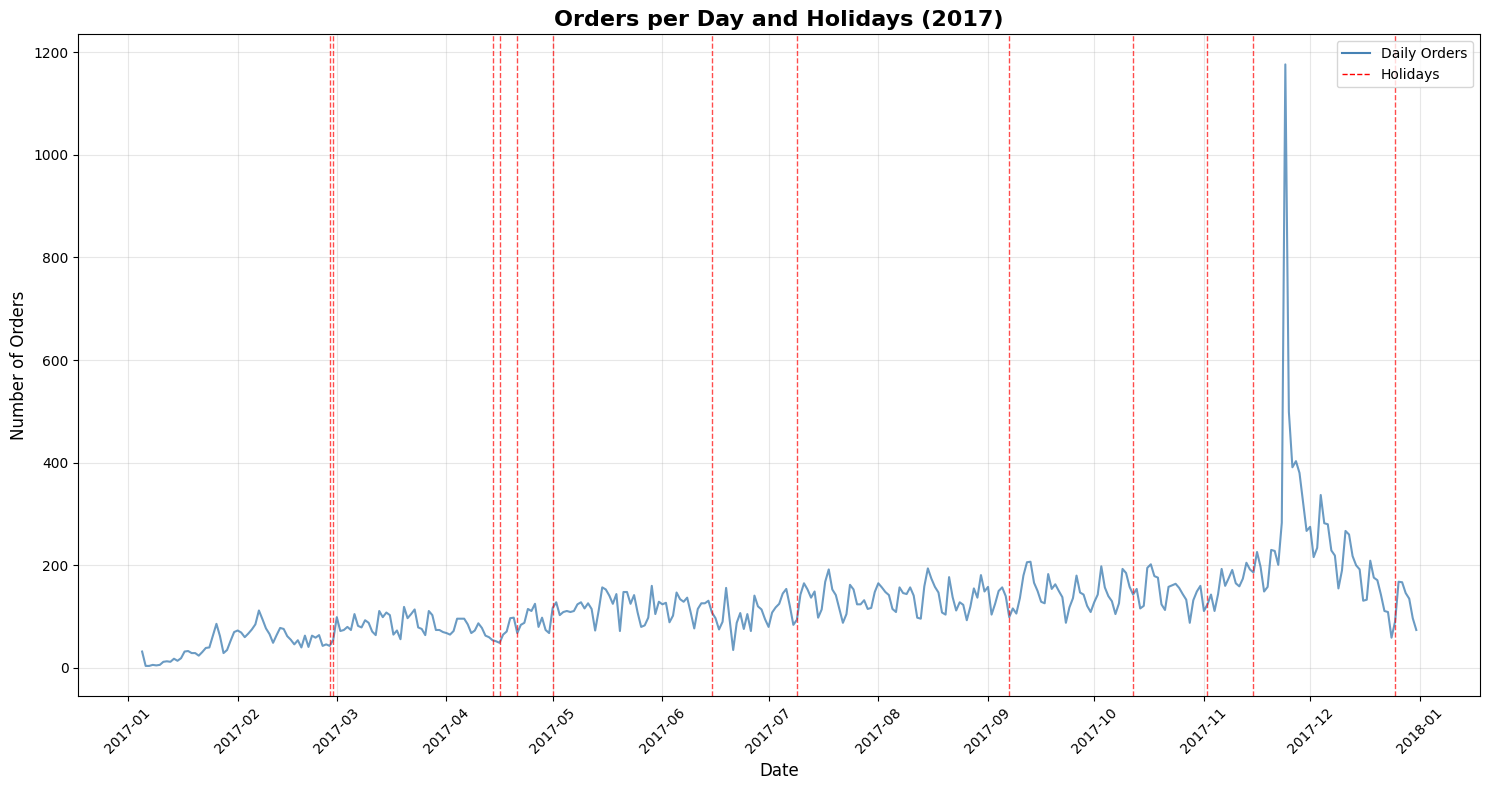

In [25]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

El gráfico de Pedidos por Día y Días Festivos que programarás en **src/plots.py** debe ser similar a este:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 ¿Ves alguna relación entre los días festivos en Brasil durante 2017 y las compras de ese año?

Respuesta: ________

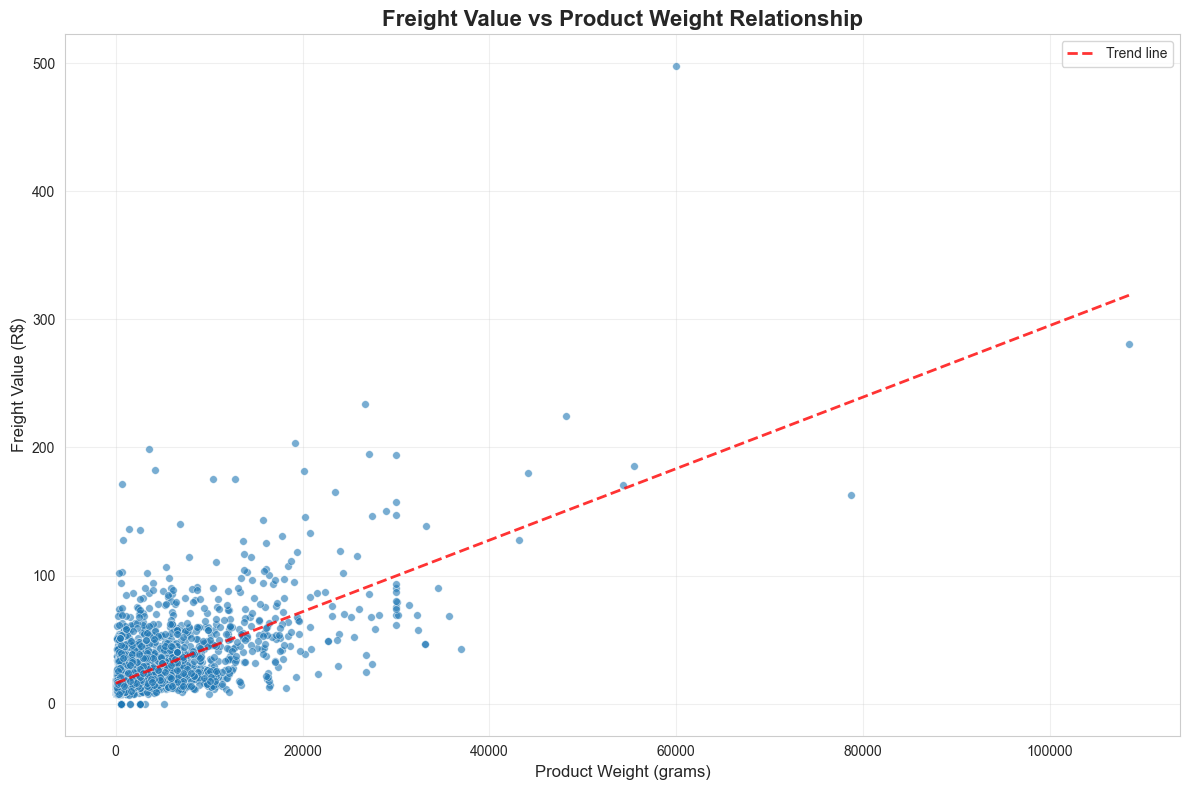

In [26]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

El gráfico sobre la relación entre el valor del flete y el peso del producto que debes programar en `src/plots.py` tiene que ser similar a este:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 ¿Ves alguna correlación entre el valor del flete y el peso del producto?

Respuesta:____